In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"raameetrajsinh","key":"bb89c905517ce420ed978a1c7d990b61"}'}

In [2]:
import os
import shutil

In [3]:
os.makedirs('/root/.kaggle',exist_ok=True)
shutil.move('kaggle.json','/root/.kaggle')
os.chmod('/root/.kaggle/kaggle.json',600)

Error: Destination path '/root/.kaggle/kaggle.json' already exists

In [4]:
!kaggle datasets download -d andrewmvd/car-plate-detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection
License(s): CC0-1.0
car-plate-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip /content/car-plate-detection.zip -d /content/car-plate-detection

Archive:  /content/car-plate-detection.zip
replace /content/car-plate-detection/annotations/Cars0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split

In [7]:
import torch



In [8]:
print(f"{torch.cuda.is_available() = }")

torch.cuda.is_available() = True


In [ ]:
 !pip install ultralytics

In [ ]:
 !pip install ipywidgets

In [9]:
dataset_path = '/content/car-plate-detection'

In [10]:
import re


In [11]:
def the_number_in_the_String(filename):
    """
    """
    match = re.search(r'(\d+)',filename)

    if match:
        return int(match.group(0))
    else:
        return 0


In [12]:
the_number_in_the_String('filename.txt')

0

Formmating XML file  -> creating DF


In [13]:
labels_dict = dict(
    img_path = [],
    xmin=[],
    xmax=[],
    ymin=[],
    ymax=[],
    img_w=[],
    img_h=[]
)

# get the list of XML files from annotations dir
xml_files = glob(f'{dataset_path}/annotations/*.xml')


for filename in sorted(xml_files,key=the_number_in_the_String):
    info = xet.parse(filename)
    root = info.getroot()

    member_object = root.find('object')
    label_info = member_object.find('bndbox')
    x_min = int(label_info.find('xmin').text)
    x_max = int(label_info.find('xmax').text)
    y_min = int(label_info.find('ymin').text)
    y_max = int(label_info.find('ymax').text)


    img_labels = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_labels)

    height,width, _ = cv2.imread(img_path).shape

    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(x_min)
    labels_dict['xmax'].append(x_max)
    labels_dict['ymin'].append(y_min)
    labels_dict['ymax'].append(y_max)
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)

all_data=pd.DataFrame(labels_dict)

In [14]:
all_data

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,/content/car-plate-detection/images/Cars0.png,226,419,125,173,500,268
1,/content/car-plate-detection/images/Cars1.png,134,262,128,160,400,248
2,/content/car-plate-detection/images/Cars2.png,229,270,176,193,400,400
3,/content/car-plate-detection/images/Cars3.png,142,261,128,157,400,225
4,/content/car-plate-detection/images/Cars4.png,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,/content/car-plate-detection/images/Cars428.png,142,258,128,157,400,225
429,/content/car-plate-detection/images/Cars429.png,86,208,166,195,301,400
430,/content/car-plate-detection/images/Cars430.png,38,116,159,197,400,225
431,/content/car-plate-detection/images/Cars431.png,55,343,82,147,400,192


In [15]:
train,test = train_test_split(all_data,test_size=1/10)

train,val = train_test_split(train,train_size=8/9)

In [16]:
print(f'''
len(train) = {len(train)}
len(test) = {len(test)}
len(val) = {len(val)}

''')


len(train) = 345
len(test) = 44
len(val) = 44




In [17]:
def make_split_folder_in_yolo_format(split_name,split_df):
  labels_path = os.path.join('datasets','car-plate-detection',split_name,'labels')
  images_path = os.path.join('datasets','car-plate-detection',split_name,'images')

  os.makedirs(labels_path,exist_ok=True)
  os.makedirs(images_path,exist_ok=True)

  for index,row in split_df.iterrows():
    img_name,img_extn = os.path.splitext(os.path.basename(row['img_path']))

    x_c = (row['xmin']+row['xmax']) / 2 / row['img_w']
    y_c = (row['ymin']+row['ymax']) / 2 / row['img_h']
    width = (row['xmax']-row['xmin']) / row['img_w']
    height = (row['ymax']-row['ymin']) / row['img_h']

    label_path = os.path.join(labels_path,f'{img_name}.txt')
    with open(label_path,'w') as file:
      file.write(f'0 {x_c:.4f} {y_c:.4f} {width:.4f} {height:.4f}')


    shutil.copy(row['img_path'],os.path.join(images_path,img_name+img_extn))
  print(f"Created '{images_path}, and {labels_path }")

In [18]:
make_split_folder_in_yolo_format('train',train)
make_split_folder_in_yolo_format('Val',val)
make_split_folder_in_yolo_format('test',test)

Created 'datasets/car-plate-detection/train/images, and datasets/car-plate-detection/train/labels
Created 'datasets/car-plate-detection/Val/images, and datasets/car-plate-detection/Val/labels
Created 'datasets/car-plate-detection/test/images, and datasets/car-plate-detection/test/labels


In [19]:
# img_name,img_extn = os.path.splitext(os.path.basename(row['img_path']))

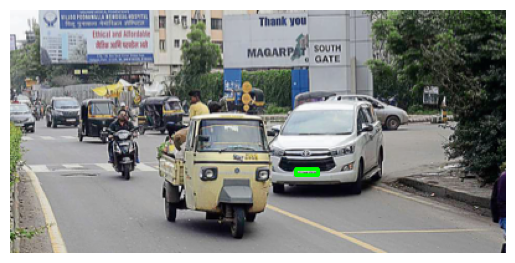

In [20]:

# Directory paths
image_dir = '/content/datasets/car-plate-detection/train/images'
label_dir = '/content/datasets/car-plate-detection/train/labels'

# Get the first image file
image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[5]

# Construct paths for the image and its corresponding label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

# Load the image using OpenCV
image = cv2.imread(image_path)
# Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the label file to get bounding box information
with open(label_path, 'r') as f:
    lines = f.readlines()

# Plot the bounding box on the image
for line in lines:
    # Parse the label file line to extract bounding box information
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    # Calculate the top-left and bottom-right coordinates of the bounding box
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    # Draw the bounding box on the image using a green rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image with bounding box using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()  # Display the image

In [21]:
datasets_yaml = '''
path: /content/datasets/car-plate-detection

train: train/images
val: Val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']

'''
with open('datasets.yaml','w') as f:
  f.write(datasets_yaml)


In [ ]:
# shutil.move('license_plate.yaml','/content/car-plate-detection')

In [ ]:
# !pip install ultralytics

In [22]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [23]:
model=YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 186MB/s]


In [24]:
model.train(data='datasets.yaml',epochs=10, device='cuda',batch=8)

Ultralytics 8.3.139 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fals

100%|██████████| 755k/755k [00:00<00:00, 127MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 169MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2065.5±1153.3 MB/s, size: 511.7 KB)


train: Scanning /content/datasets/car-plate-detection/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<00:00, 942.05it/s]

train: New cache created: /content/datasets/car-plate-detection/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1407.9±800.9 MB/s, size: 502.0 KB)


val: Scanning /content/datasets/car-plate-detection/Val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 347.73it/s]

val: New cache created: /content/datasets/car-plate-detection/Val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.11G      1.594      3.538      1.369          1        640: 100%|██████████| 44/44 [00:11<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all         44         44    0.00326      0.977      0.143     0.0773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.24G      1.561      2.685       1.42          1        640: 100%|██████████| 44/44 [00:08<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         44         44      0.697      0.818      0.821      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.26G      1.612      2.508      1.481          1        640: 100%|██████████| 44/44 [00:08<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]

                   all         44         44      0.687      0.549      0.678      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.28G      1.586      2.304      1.436          1        640: 100%|██████████| 44/44 [00:09<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.28it/s]


                   all         44         44      0.934      0.773      0.831      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10       1.3G      1.521      2.006      1.414          1        640: 100%|██████████| 44/44 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.27it/s]

                   all         44         44      0.915      0.733      0.865      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.32G      1.477      1.825      1.354          1        640: 100%|██████████| 44/44 [00:08<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]

                   all         44         44      0.793      0.795      0.801      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.33G      1.373       1.59      1.291          1        640: 100%|██████████| 44/44 [00:07<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         44         44      0.816      0.909      0.884      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.35G      1.455      1.643      1.316          1        640: 100%|██████████| 44/44 [00:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.76it/s]

                   all         44         44      0.863      0.861      0.851      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.37G      1.392      1.486      1.279          1        640: 100%|██████████| 44/44 [00:09<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

                   all         44         44      0.882      0.909      0.916      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.38G      1.369      1.397       1.27          1        640: 100%|██████████| 44/44 [00:08<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]

                   all         44         44      0.851      0.886      0.912      0.559



10 epochs completed in 0.029 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.139 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


                   all         44         44      0.837      0.886      0.911       0.56
Speed: 0.2ms preprocess, 3.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c85cc3cd350>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

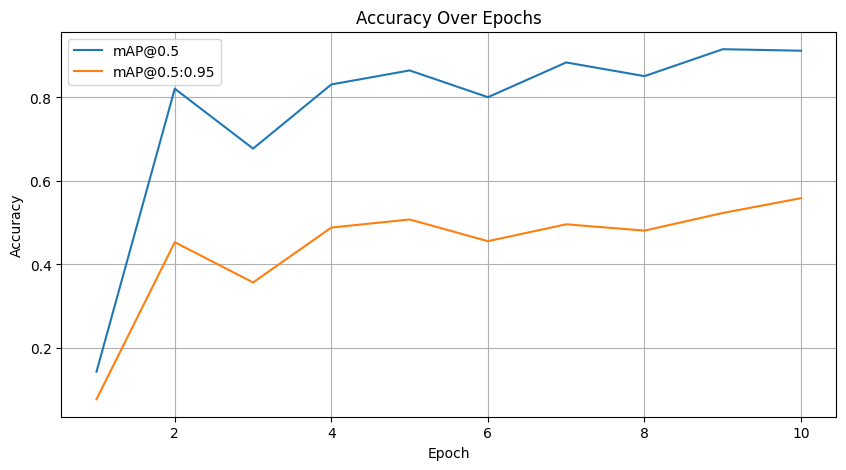

In [25]:
# Find the most recent training log directory
log_dir = max(glob('runs/detect/train*'), key=the_number_in_the_String)

# Load the training results from the CSV file
results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()  # Remove any leading/trailing whitespace from column names

# Extract epochs and accuracy metrics
epochs = results.index + 1  # Epochs are zero-indexed, so add 1
mAP_0_5 = results['metrics/mAP50(B)']  # Mean Average Precision at IoU=0.5
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']  # Mean Average Precision at IoU=0.5:0.95

# Plot the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Save the trained model
model.save('best_license_plate_model.pt')

In [39]:
def predict_and_plot_1(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.

    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /content/datasets/car-plate-detection/test/images/Cars109.png: 448x640 1 license_plate, 206.0ms
Speed: 3.8ms preprocess, 206.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


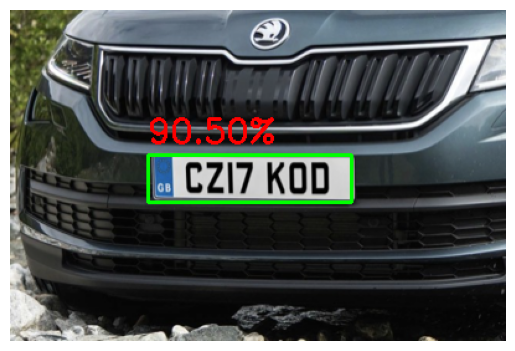

In [40]:
predict_and_plot_1("/content/datasets/car-plate-detection/test/images/Cars109.png")

In [34]:
# pip install pytesseract

In [35]:
import pytesseract

In [41]:
def predict_and_plot(path_test_car):
  results = model.predict(path_test_car, device='cuda')

  image = cv2.imread(path_test_car)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  for result in results:
    for box in result.boxes:
      x1, y1, x2, y2 = map(int, box.xyxy[0])

            # Get the confidence score of the prediction
      confidence = box.conf[0]

            # Draw the bounding box on the image
      cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
      cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

  roi = image[y1:y2, x1:x2]

  text = pytesseract.image_to_string(roi,config='--psm 6')
  # --psm6 assumes a single block of text(like a line or plate number)

  print(f"detected text: {text}")

In [42]:
predict_and_plot("/content/datasets/car-plate-detection/test/images/Cars109.png")


image 1/1 /content/datasets/car-plate-detection/test/images/Cars109.png: 448x640 1 license_plate, 88.6ms
Speed: 2.4ms preprocess, 88.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)
detected text: 4 CZI7 KOD



In [43]:
model.save("best_license_palte_model_2.pt")